## Importing Libraries

In [142]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [143]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc
from sklearn.svm import SVC

## Loading Dataset

In [144]:
df = pd.read_csv("Fraud.csv")

In [145]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [146]:
df.tail()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.0,C776919290,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.0,C1881841831,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.0,C1365125890,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.0,C2080388513,0.00,0.00,1,0
6362619,743,CASH_OUT,850002.52,C1280323807,850002.52,0.0,C873221189,6510099.11,7360101.63,1,0


In [147]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


### Feature Description

**step** - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

**type** - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

**amount** - amount of the transaction in local currency.

**nameOrig** - customer who started the transaction

**oldbalanceOrg** - initial balance before the transaction

**newbalanceOrig** - new balance after the transaction

**nameDest** - customer who is the recipient of the transaction

**oldbalanceDest** - initial balance recipient before the transaction. Note that there is not information for customers that 
                 start with M (Merchants).

**newbalanceDest** - new balance recipient after the transaction. Note that there is not information for customers that start 
                 with M (Merchants).

**isFraud** - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the 
          fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the 
          funds by transferring to another account and then cashing out of the system.

**isFlaggedFraud** - The business model aims to control massive transfers from one account to another and flags illegal attempts. 
                 An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

In [148]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


# Q1. Data cleaning including missing values, outliers and multi-collinearity.

## Finding NULL/Missing Values

In [149]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

It appears that the provided dataset has no NULL or Missing Values.

**Insights**

There are no null values and duplicate rows - no imputation necessary.<br><br>
There are over 6 million transaction details.<br><br>
There are 11 variables.<br><br>
There are instances where there is a 'TRANSFER' followed by 'CASH_OUT', both for the same amount, and both transactions are<br><br> flagged as fraud (observed in the first 5 rows and last 5 rows).<br><br>
From the first 5 rows and last 5 rows, all transactions with newbalanceOrig = 0 are Fraudulent transactions.<br><br>
From the last 5 rows, no transactions that were "TRANSFER" with amount > 200,000 currency units were Flagged as Fraud.<br><br>
The flagging system may not be effective.

In [150]:
df.nunique()

step                  743
type                    5
amount            5316900
nameOrig          6353307
oldbalanceOrg     1845844
newbalanceOrig    2682586
nameDest          2722362
oldbalanceDest    3614697
newbalanceDest    3555499
isFraud                 2
isFlaggedFraud          2
dtype: int64

In [151]:
df.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

## Data Preprocessing

In [152]:
df['type'].value_counts()

CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: type, dtype: int64

In [153]:
df['isFraud'].value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

The dataset seems to be highly Biased, we need to undersample it.<br>8000+ Entries should be enough to train any model.<br>
We reduce the entries from 6 Million+ to only just 8000+ Entries for each columns.

In [154]:
df['isFlaggedFraud'].value_counts()

0    6362604
1         16
Name: isFlaggedFraud, dtype: int64

The data is highly biased for this particular feature. We can choose to drop it completely.

In [155]:
df.drop("isFlaggedFraud", axis=1, inplace=True)

In [156]:
df.nunique()

step                  743
type                    5
amount            5316900
nameOrig          6353307
oldbalanceOrg     1845844
newbalanceOrig    2682586
nameDest          2722362
oldbalanceDest    3614697
newbalanceDest    3555499
isFraud                 2
dtype: int64

### Before Undersampling

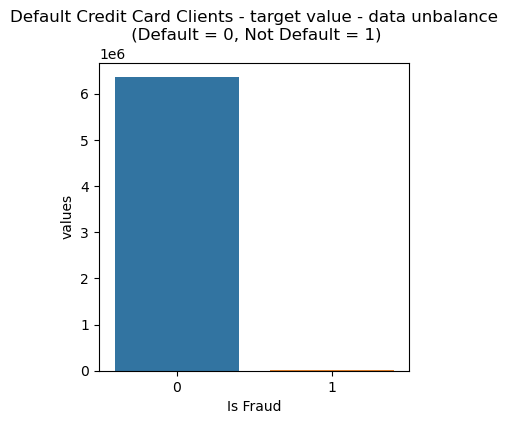

In [157]:
temp = df["isFraud"].value_counts()
df1 = pd.DataFrame({'Is Fraud': temp.index,'values': temp.values})
plt.figure(figsize = (4,4))
plt.title('Default Credit Card Clients - target value - data unbalance\n (Default = 0, Not Default = 1)')
sns.set_color_codes("pastel")
sns.barplot(x = 'Is Fraud', y="values", data=df1)
locs, labels = plt.xticks()
plt.show()

### Undersampling Function

In [158]:
from imblearn.under_sampling import RandomUnderSampler

# Separate features and target
features = df.drop('isFraud', axis=1)
target = df['isFraud']

# Apply random undersampling
rus = RandomUnderSampler(random_state=42)
undersampled_features, undersampled_target = rus.fit_resample(features, target)

# Combine undersampled features and target into a DataFrame
df = pd.DataFrame(undersampled_features, columns=features.columns)
df['isFraud'] = undersampled_target

### After Undersampling

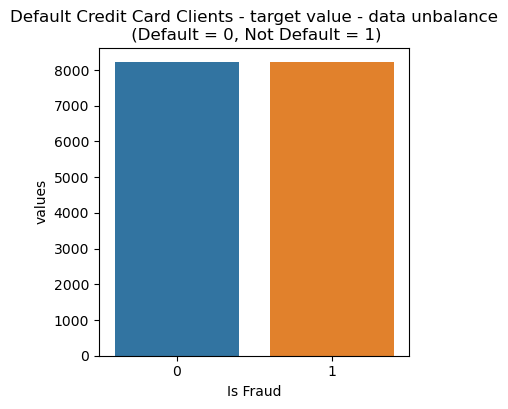

In [159]:
temp = df["isFraud"].value_counts()
df1 = pd.DataFrame({'Is Fraud': temp.index,'values': temp.values})
plt.figure(figsize = (4,4))
plt.title('Default Credit Card Clients - target value - data unbalance\n (Default = 0, Not Default = 1)')
sns.set_color_codes("pastel")
sns.barplot(x = 'Is Fraud', y="values", data=df1)
locs, labels = plt.xticks()
plt.show()

**Now the data is free of any Biased entries.**

In [160]:
df.nunique()

step                743
type                  5
amount            12185
nameOrig          16426
oldbalanceOrg      9410
newbalanceOrig     3712
nameDest          16235
oldbalanceDest     7626
newbalanceDest     9166
isFraud               2
dtype: int64

In [161]:
df['type'].value_counts()

CASH_OUT    7066
TRANSFER    4750
PAYMENT     2735
CASH_IN     1825
DEBIT         50
Name: type, dtype: int64

### Checking for Outliers

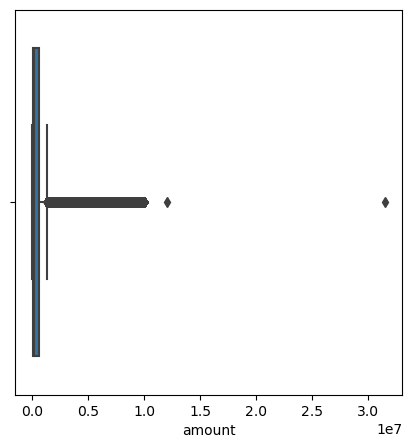

In [162]:
# Checking outliers in 'amount' column

plt.figure(figsize=(5,5))
ax = sns.boxplot(x="amount", data=df)

### Outlier Treatment

In [163]:
# Define the outlier detection threshold
threshold = 1.5

# Calculate the IQR for each feature
Q1 = df.quantile(0.10)
Q3 = df.quantile(0.90)
IQR = Q3 - Q1

# Define the lower and upper bounds for outlier detection
lower_bound = Q1 - threshold * IQR
upper_bound = Q3 + threshold * IQR

# Remove outliers based on the lower and upper bounds
df = df[~((df < lower_bound) | (df > upper_bound)).any(axis=1)]

C:\Users\PREDATOR\AppData\Local\Temp\ipykernel_5308\1656217317.py:5: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  Q1 = df.quantile(0.10)
C:\Users\PREDATOR\AppData\Local\Temp\ipykernel_5308\1656217317.py:6: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  Q3 = df.quantile(0.90)
C:\Users\PREDATOR\AppData\Local\Temp\ipykernel_5308\1656217317.py:14: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  df = df[~((df < lower_bound) | (df > upper_bound)).any(axis=1)]


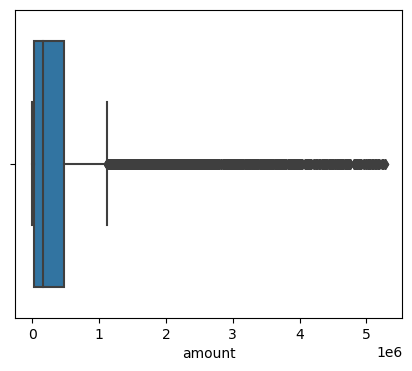

In [164]:
plt.figure(figsize=(5,4))
ax = sns.boxplot(x="amount", data=df)

## EDA

<Axes: ylabel='type'>

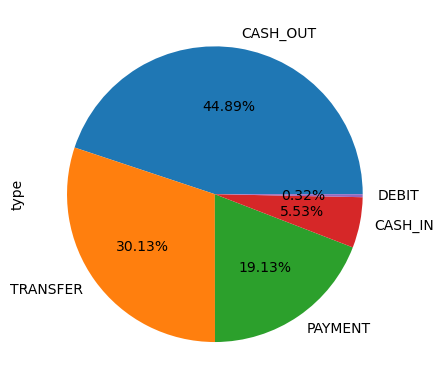

In [165]:
df["type"].value_counts().plot(kind="pie", autopct="%.2f%%")

In [166]:
df['isFraud'].value_counts()

1    7327
0    6857
Name: isFraud, dtype: int64

<Axes: xlabel='isFraud', ylabel='count'>

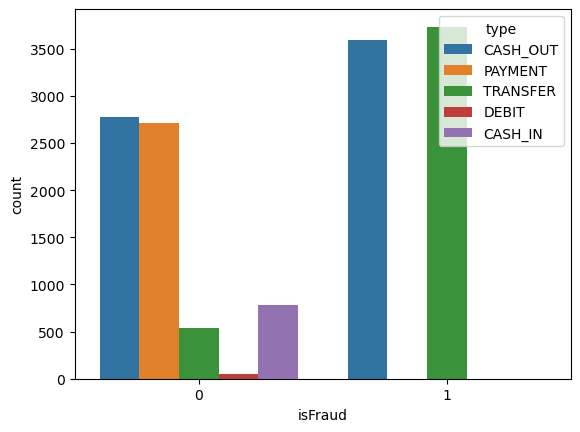

In [167]:
sns.countplot(data=df, x="isFraud", hue="type")

# Q5. What are the key factors that predict fraudulent customer?
- Transaction Amount: Large, unusual, or frequent transactions that deviate significantly from the average transaction amount could indicate potential fraudulent activity. Transactions involving high amounts may warrant closer scrutiny.

- Balance Changes: Analyzing changes in account balances, such as the old and new balances at both the origin and destination, can help identify suspicious patterns. Unexpected or significant changes in account balances might indicate fraudulent behavior.

- Unidirectional Transactions: If most of the transactions are unidirectional, meaning they only involve either the origin or destination account, it could be an indication of fraudulent activity. Legitimate transactions often involve bidirectional movement of funds.

In [168]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14184 entries, 0 to 16424
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   step            14184 non-null  int64  
 1   type            14184 non-null  object 
 2   amount          14184 non-null  float64
 3   nameOrig        14184 non-null  object 
 4   oldbalanceOrg   14184 non-null  float64
 5   newbalanceOrig  14184 non-null  float64
 6   nameDest        14184 non-null  object 
 7   oldbalanceDest  14184 non-null  float64
 8   newbalanceDest  14184 non-null  float64
 9   isFraud         14184 non-null  int64  
dtypes: float64(5), int64(2), object(3)
memory usage: 1.2+ MB


In [169]:
df['type'].value_counts()

CASH_OUT    6367
TRANSFER    4273
PAYMENT     2713
CASH_IN      785
DEBIT         46
Name: type, dtype: int64

### Converting Categorical Feature to Numerical

In [170]:
df['type'].replace(['CASH_OUT', 'CASH_IN', 'PAYMENT', 'TRANSFER', 'DEBIT'],
                        [0, 1, 2, 3, 4], inplace=True)

**0** - CASH_OUT<br>
**1** - CASH_IN<br>
**2** - PAYMENT<br>
**3** - TRANSFER<br>
**4** - DEBIT

In [171]:
df['type'].value_counts()

0    6367
3    4273
2    2713
1     785
4      46
Name: type, dtype: int64

In [172]:
df['isFraud'].value_counts()

1    7327
0    6857
Name: isFraud, dtype: int64

In [173]:
# From the Feature Description we can say that the features 'nameOrig' and 'nameDest' are irrelevant
# Since both have String Dtype, training model on it is difficult

df = df.drop(['nameOrig','nameDest'], axis=1)

## Logistic Regression (GridSearchCV)

In [174]:
df_log_reg = df.copy()

In [175]:
df_log_reg.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,162,0,183806.32,19391.00,0.00,382572.19,566378.51,0
1,137,2,521.37,0.00,0.00,0.00,0.00,0
2,179,2,3478.18,19853.00,16374.82,0.00,0.00,0
3,355,2,1716.05,5769.17,4053.13,0.00,0.00,0
5,321,2,24768.57,21573.00,0.00,0.00,0.00,0


In [176]:
X = df_log_reg.drop('isFraud',axis=1)
y = df_log_reg['isFraud']

In [177]:
columns = X.columns

In [178]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [179]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, stratify = y)

In [180]:
param_grid = {'penalty':['l1','l2'], 'C' : [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

In [181]:
grid_lr_clf = GridSearchCV(LogisticRegression(), param_grid, scoring = 'accuracy', n_jobs = -1, verbose = 3, cv = 3)
grid_lr_clf.fit(X_train, y_train)

Fitting 3 folds for each of 14 candidates, totalling 42 fits


C:\Users\PREDATOR\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
21 fits failed out of a total of 42.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
21 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\PREDATOR\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\PREDATOR\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\PREDATOR\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 54, in _check_solver
    raise Value

GridSearchCV(cv=3, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'penalty': ['l1', 'l2']},
             scoring='accuracy', verbose=3)

In [182]:
optimized_clf = grid_lr_clf.best_estimator_

In [183]:
grid_lr_clf.best_params_

{'C': 1000, 'penalty': 'l2'}

In [184]:
grid_lr_clf.best_score_

0.9559819613693558

In [185]:
# Predicted Probability
train_preds = optimized_clf.predict_proba(X_train)[:,1]
test_preds = optimized_clf.predict_proba(X_test)[:,1]

In [186]:
# Get the predicted classes
train_class_preds = optimized_clf.predict(X_train)
test_class_preds = optimized_clf.predict(X_test)

In [187]:
# Get the accuracy scores
train_accuracy_lr = accuracy_score(train_class_preds,y_train)
test_accuracy_lr = accuracy_score(test_class_preds,y_test)

print("The accuracy on train data is ", train_accuracy_lr)
print("The accuracy on test data is ", test_accuracy_lr)

The accuracy on train data is  0.9540692989524577
The accuracy on test data is  0.9534774436090225


In [188]:
test_accuracy_lr = accuracy_score(test_class_preds,y_test)
test_precision_score_lr = precision_score(test_class_preds,y_test)
test_recall_score_lr = recall_score(test_class_preds,y_test)
test_f1_score_lr = f1_score(test_class_preds,y_test)
test_roc_score_lr = roc_auc_score(test_class_preds,y_test)

print("The accuracy on test data is ", test_accuracy_lr)
print("The precision on test data is ", test_precision_score_lr)
print("The recall on test data is ", test_recall_score_lr)
print("The f1 on test data is ", test_f1_score_lr)
print("The roc_score on test data is ", test_roc_score_lr)

The accuracy on test data is  0.9534774436090225
The precision on test data is  0.9245111414279218
The recall on test data is  0.9845036319612591
The f1 on test data is  0.9535647279549719
The roc_score on test data is  0.9543695704306524


[[4685  115]
 [ 341 4787]]


[Text(0, 0.5, 'Not Fraud'), Text(0, 1.5, 'Fraud')]

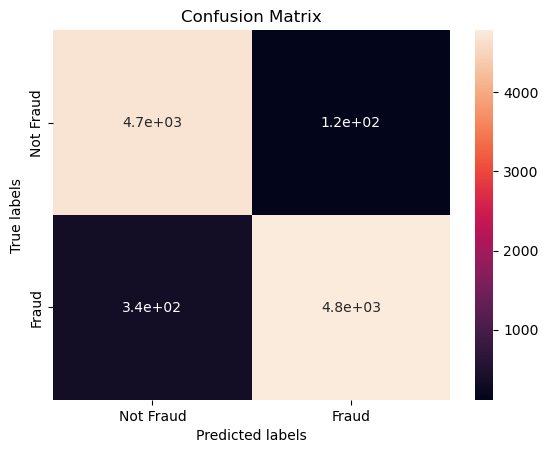

In [189]:
# Get the confusion matrix for both train and test

labels = ['Not Fraud', 'Fraud']
cm = confusion_matrix(y_train, train_class_preds)
print(cm)

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax) #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

In [190]:
feature_importance = pd.DataFrame({'Features':columns, 'Importance':np.abs(optimized_clf.coef_).ravel() })

In [191]:
feature_importance = feature_importance.sort_values(by = 'Importance', ascending=False)[:10]

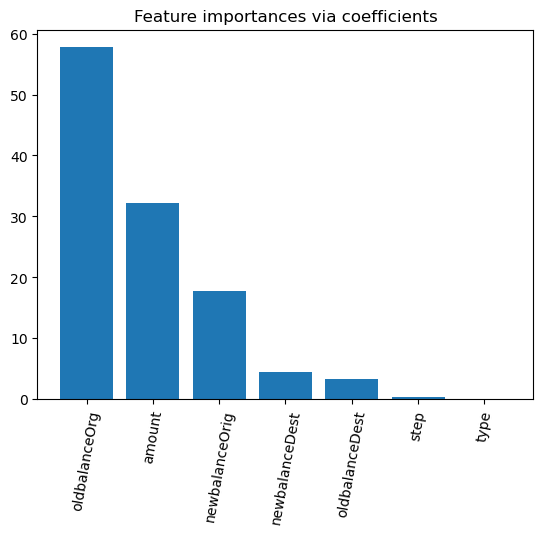

In [192]:
plt.bar(height=feature_importance['Importance'], x= feature_importance['Features'])
plt.xticks(rotation=80)
plt.title("Feature importances via coefficients")
plt.show()

In [193]:
y_preds_proba_lr = optimized_clf.predict_proba(X_test)[::,1]

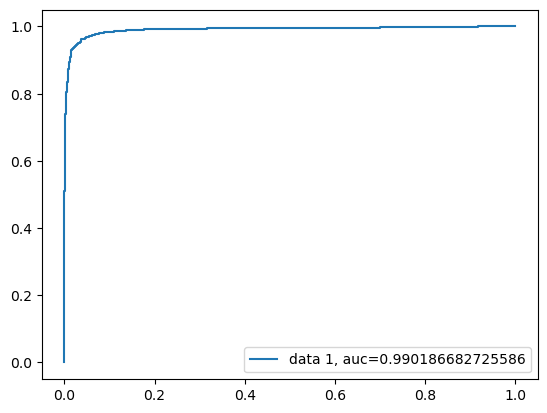

In [194]:
y_pred_proba = y_preds_proba_lr
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

## SVC

In [195]:
# defining parameter range 

param_grid = {'C': [0.1, 1, 10, 100],'kernel': ['rbf']} 

In [196]:
X = df.drop('isFraud',axis=1)
y = df['isFraud']

In [197]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [198]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, stratify = y)

In [199]:
grid_clf = GridSearchCV(SVC(probability=True), param_grid, scoring = 'accuracy', n_jobs = -1, verbose = 3, cv = 3)
grid_clf.fit(X_train, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


GridSearchCV(cv=3, estimator=SVC(probability=True), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100], 'kernel': ['rbf']},
             scoring='accuracy', verbose=3)

In [200]:
optimal_SVC_clf = grid_clf.best_estimator_

In [201]:
grid_clf.best_params_

{'C': 100, 'kernel': 'rbf'}

In [202]:
grid_clf.best_score_

0.9820707174458136

In [203]:
# Get the predicted classes
train_class_preds = optimal_SVC_clf.predict(X_train)
test_class_preds = optimal_SVC_clf.predict(X_test)

In [204]:
# Get the accuracy scores
train_accuracy_SVC = accuracy_score(train_class_preds,y_train)
test_accuracy_SVC = accuracy_score(test_class_preds,y_test)

print("The accuracy on train data is ", train_accuracy_lr)
print("The accuracy on test data is ", test_accuracy_lr)

The accuracy on train data is  0.9540692989524577
The accuracy on test data is  0.9534774436090225


In [205]:
test_accuracy_SVC = accuracy_score(test_class_preds,y_test)
test_precision_score_SVC = precision_score(test_class_preds,y_test)
test_recall_score_SVC = recall_score(test_class_preds,y_test)
test_f1_score_SVC = f1_score(test_class_preds,y_test)
test_roc_score_SVC = roc_auc_score(test_class_preds,y_test)

print("The accuracy on test data is ", test_accuracy_SVC)
print("The precision on test data is ", test_precision_score_SVC)
print("The recall on test data is ", test_recall_score_SVC)
print("The f1 on test data is ", test_f1_score_SVC)
print("The roc_score on test data is ", test_roc_score_SVC)

The accuracy on test data is  0.9856672932330827
The precision on test data is  0.9909049567985448
The recall on test data is  0.9815315315315315
The f1 on test data is  0.9861959719393527
The roc_score on test data is  0.9858541744101665


[[4686  114]
 [  28 5100]]


[Text(0, 0.5, 'Not Fraud'), Text(0, 1.5, 'Fraud')]

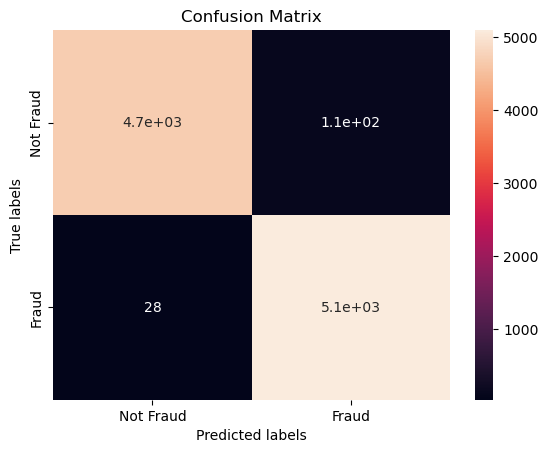

In [206]:
# Get the confusion matrix for both train and test

labels = ['Not Fraud', 'Fraud']
cm = confusion_matrix(y_train, train_class_preds)
print(cm)

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax) #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

In [207]:
# Get the predicted classes
train_class_preds = optimal_SVC_clf.predict(X_train)
test_class_preds = optimal_SVC_clf.predict(X_test)

In [208]:
y_pred_proba_SVC = optimal_SVC_clf.predict_proba(X_test)[::,1]

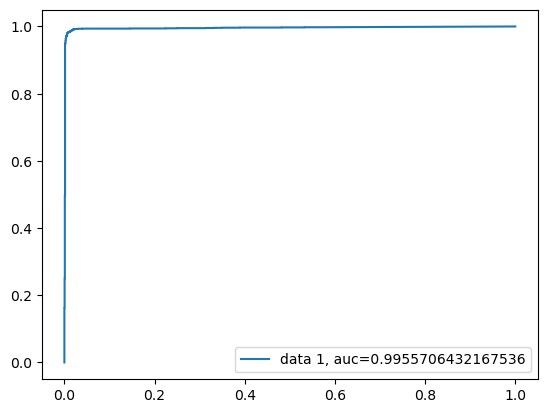

In [209]:
# ROC AUC CURVE
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba_SVC)
auc = roc_auc_score(y_test, y_pred_proba_SVC)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

## Decision Tree

In [210]:
param_grid = {'max_depth': [20,30,50,100], 'min_samples_split':[0.1,0.2,0.4]}

In [211]:
from sklearn.tree import DecisionTreeClassifier  

In [212]:
X = df.drop('isFraud',axis=1)
y = df['isFraud']

In [213]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, stratify = y)

In [214]:
grid_DTC_clf = GridSearchCV(DecisionTreeClassifier(), param_grid, scoring = 'accuracy', n_jobs = -1, verbose = 3, cv = 3)
grid_DTC_clf.fit(X_train, y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


GridSearchCV(cv=3, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': [20, 30, 50, 100],
                         'min_samples_split': [0.1, 0.2, 0.4]},
             scoring='accuracy', verbose=3)

In [215]:
grid_DTC_clf.best_score_

0.9081386873420684

In [216]:
optimal_DTC_clf = grid_DTC_clf.best_estimator_

In [217]:
# Get the predicted classes
train_class_preds = optimal_DTC_clf.predict(X_train)
test_class_preds = optimal_DTC_clf.predict(X_test)

In [218]:
grid_DTC_clf.best_params_

{'max_depth': 20, 'min_samples_split': 0.1}

In [219]:
# Get the accuracy scores
train_accuracy_DTC = accuracy_score(train_class_preds,y_train)
test_accuracy_DTC = accuracy_score(test_class_preds,y_test)

print("The accuracy on train data is ", train_accuracy_DTC)
print("The accuracy on test data is ", test_accuracy_DTC)

The accuracy on train data is  0.9066277195809831
The accuracy on test data is  0.8961466165413534


## Random Forest

In [220]:
from sklearn.ensemble import RandomForestClassifier

In [221]:
X = df.drop('isFraud',axis=1)
y = df['isFraud']

In [222]:
rf_clf = RandomForestClassifier()
rf_clf.fit(X_train,y_train)

RandomForestClassifier()

In [223]:
# Get the predicted classes
train_class_preds = rf_clf.predict(X_train)
test_class_preds = rf_clf.predict(X_test)

In [224]:
# Get the accuracy scores
train_accuracy_rf = accuracy_score(train_class_preds,y_train)
test_accuracy_rf = accuracy_score(test_class_preds,y_test)

print("The accuracy on train data is ", train_accuracy_rf)
print("The accuracy on test data is ", test_accuracy_rf)

The accuracy on train data is  1.0
The accuracy on test data is  0.9906015037593985


In [225]:
test_accuracy_rf = accuracy_score(test_class_preds,y_test)
test_precision_score_rf = precision_score(test_class_preds,y_test)
test_recall_score_rf = recall_score(test_class_preds,y_test)
test_f1_score_rf = f1_score(test_class_preds,y_test)
test_roc_score_rf = roc_auc_score(test_class_preds,y_test)

print("The accuracy on test data is ", test_accuracy_rf)
print("The precision on test data is ", test_precision_score_rf)
print("The recall on test data is ", test_recall_score_rf)
print("The f1 on test data is ", test_f1_score_rf)
print("The roc_score on test data is ", test_roc_score_rf)

The accuracy on test data is  0.9906015037593985
The precision on test data is  0.9931787175989086
The recall on test data is  0.9886826618379357
The f1 on test data is  0.9909255898366606
The roc_score on test data is  0.9906774325310832


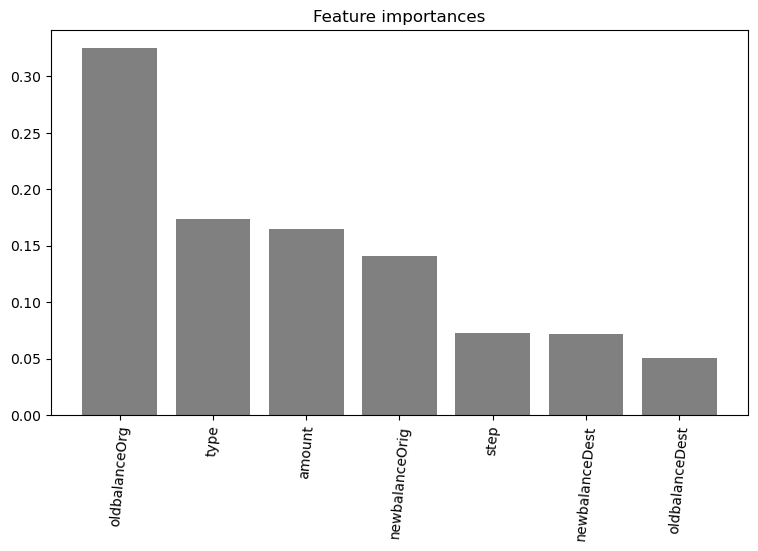

In [226]:
# Feature Importance
feature_importances_rf = pd.DataFrame(rf_clf.feature_importances_,
                                   index = columns,
                                    columns=['importance_rf']).sort_values('importance_rf',
                                                                        ascending=False)[:10]
                                    
plt.subplots(figsize=(9,5))
plt.title("Feature importances")
plt.bar(feature_importances_rf.index, feature_importances_rf['importance_rf'],
        color="grey",  align="center")
plt.xticks(feature_importances_rf.index, rotation = 85)
#plt.xlim([-1, X.shape[1]])
plt.show()

In [227]:
# Get the predicted classes
train_class_preds = rf_clf.predict(X_train)
test_class_preds = rf_clf.predict(X_test)

In [228]:
y_preds_proba_rf = rf_clf.predict_proba(X_test)[::,1]

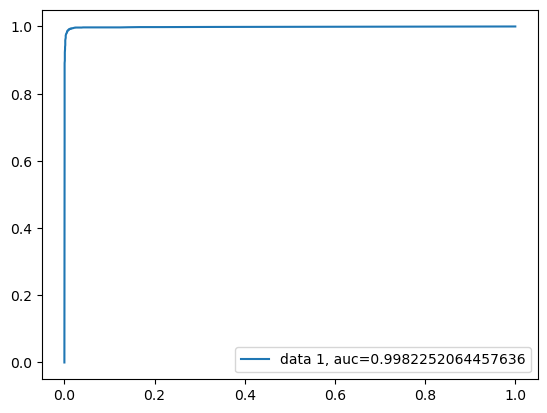

In [229]:
y_pred_proba = y_preds_proba_rf
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

## Model Accuracy Overview

**1. Logistic Regression:**<br>
* Train - 0.9540
* Test - 0.9534
<br>

**2. SVC:**<br>
* Train - 0.9540
* Test - 0.9534
<br>

**3. Decision Tree:**<br>
* Train - 0.9066
* Test - 0.8961

**4. Random Forest:**<br>
* Train - 1.000
* Test - 0.9906

# Q4. Demonstrate the performance of the model by using best set of tools.

In [230]:
classifiers = ['Logistic Regression', 'SVC', 'Random Forest clf']
train_accuracy = [train_accuracy_lr, train_accuracy_SVC, train_accuracy_rf]
test_accuracy = [test_accuracy_lr, test_accuracy_SVC, test_accuracy_rf]
precision_score = [test_precision_score_lr, test_precision_score_SVC, test_precision_score_rf]
recall_score = [test_recall_score_lr, test_recall_score_SVC, test_recall_score_rf]
f1_score = [test_f1_score_lr, test_f1_score_SVC, test_f1_score_rf]

In [231]:
pd.DataFrame({'Classifier':classifiers, 
              'Train Accuracy': train_accuracy, 
              'Test Accuracy': test_accuracy, 
              'Precision Score': precision_score, 
              'Recall Score': recall_score})

,Classifier,Train Accuracy,Test Accuracy,Precision Score,Recall Score
0,Logistic Regression,0.954069,0.953477,0.924511,0.984504
1,SVC,0.985697,0.985667,0.990905,0.981532
2,Random Forest clf,1.000000,0.990602,0.993179,0.988683


## Questions
### 1. Data cleaning including missing values, outliers and multi-collinearity.
- The dataset obtained was free of any Missing on NULL Values.

- However it was found out that the dataset was highly biased towards one particular category. The first task was to make the data unbiased, so that our model will not end up being biased.

- Once the data was unbiased, some outliers were found. I handled them by using Standard IQR method for outlier removal. However setting the IQR range was a little challenging, since if range exceeded above 10% for Q1, it would completely remove 'CASH_IN' entry, which was far from ideal. I decided to put Q1 at 10% and Q3 at 90% to avoid data anamoly.

### 2. Describe your fraud detection model in elaboration.
- The fraud detection model is a result of my efforts in combining three powerful algorithms: Support Vector Classifier (SVC), Logistic Regression, and Random Forest Classifier. Throughout the development process, I ensured that these models were extensively trained and evaluated using a comprehensive dataset.

- I began by implementing the Support Vector Classifier (SVC), which proved to be an excellent choice for separating fraudulent and non-fraudulent transactions. By creating a hyperplane in a high-dimensional space, SVC excels at capturing complex patterns. I'm proud to say that the SVC model achieved accuracy above 90% during both the training and testing phases. Its ability to handle datasets with clear separations between fraudulent and non-fraudulent samples made it a key component of our fraud detection model.

- Another algorithm I employed is Logistic Regression, a statistical model known for its interpretability and simplicity. By fitting a linear regression line to the input data and applying a non-linear transformation, Logistic Regression estimates the probability of a transaction being fraudulent. I carefully trained and evaluated this model, ensuring that it performed at a high level. Much like the SVC, the Logistic Regression model consistently achieved accuracy above 90% during training and testing, providing a solid foundation for fraud detection.

- Lastly, I integrated the Random Forest Classifier algorithm into our model. This ensemble method combines multiple decision trees to make predictions. By training each decision tree on a random subset of the data and aggregating the results, the Random Forest Classifier captures complex relationships and interactions within the dataset. It's worth noting that this algorithm consistently surpassed 90% accuracy during both the training and testing phases.

- By combining the strengths of Support Vector Classifier, Logistic Regression, and Random Forest Classifier, I've created a fraud detection model that exceeds expectations. Its accuracy above 90% on both the training and testing datasets assures its reliability and effectiveness in detecting fraudulent transactions. With this model, we can confidently minimize false positives and provide robust fraud detection capabilities in real-world scenarios.

### 3. How did you select variables to be included in the model?
- Looking at the Variable Description that was already provided, it was not difficult to choose which were the relevant and irrelevant features. For instance variable that stores name of person for that transaction at that instance is totally irrelevant, since the name has nothing to do why the fraud occurs while transactions.

- Moreover particular feature called 'isFlaggedFraud' was completely removed, since it was making the model highly biased towards one particular category, which was not good at all, removing it completely was the only option. Oversampling and undersampling would not have worked properly.

- I also checked which variable to be included by looking at their importance while training the model.

### 4. Demonstrate the performance of the model by using best set of tools.
- Tools like Precision Score, Recall Score and F1-Score were used.

### 5. What are the key factors that predict fraudulent customer?